In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [3]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [4]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [9]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

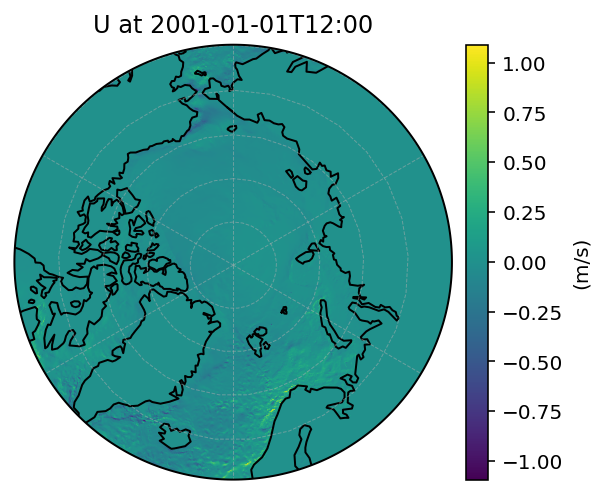

In [7]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [5]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [6]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

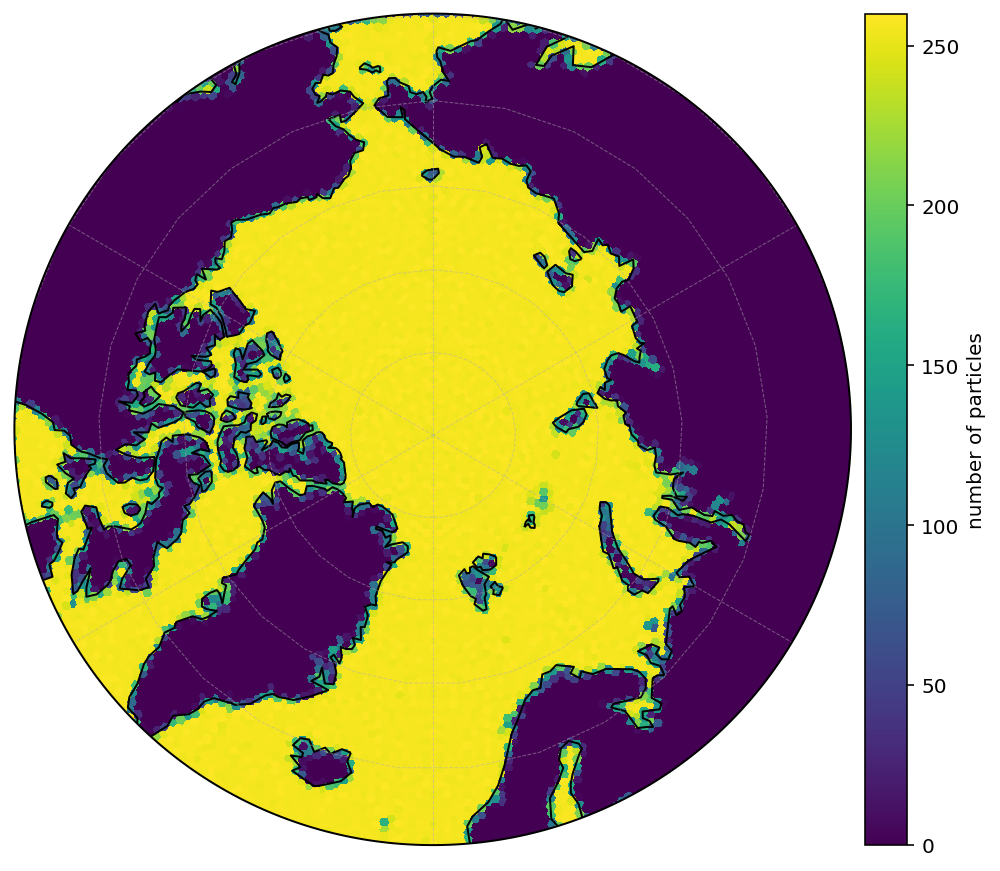

In [20]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "number of particles",
                                             size=(8,8))

## March 2010-2018 (90 Days)

In [30]:
avg_mixing_march_2010_2018 = np.zeros_like(myBins.bindex)
avg_coherence_march_2010_2018 = np.zeros_like(myBins.bindex)
avg_boundary_march_2010_2018 = np.zeros_like(myBins.bindex)
avg_global_mixing_march_2010_2018 = 0
avg_global_coherence_march_2010_2018 = 0

for year in range(2010, 2019):
    runName = f"Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24"
    comName = runName + "_Cico7_mt2"
    
    transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")
    
    myBins.load_communities(comdir + f"masked_network_{comName}.clu")
    myBins.find_adjacency();
    myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    
    avg_mixing_march_2010_2018 = avg_mixing_march_2010_2018 + myBins.mixing
    avg_coherence_march_2010_2018 = avg_coherence_march_2010_2018 + myBins.coherenceRatio
    avg_boundary_march_2010_2018 = avg_boundary_march_2010_2018 + myBins.onBoundary
    avg_global_coherence_march_2010_2018 += myBins.globalCoherenceRatio
    avg_global_mixing_march_2010_2018 += myBins.globalMixing
    
avg_mixing_march_2010_2018 = avg_mixing_march_2010_2018/9
avg_coherence_march_2010_2018 = avg_coherence_march_2010_2018/9
avg_boundary_march_2010_2018 = avg_boundary_march_2010_2018/9
avg_global_mixing_march_2010_2018 = avg_global_mixing_march_2010_2018/9
avg_global_coherence_march_2010_2018 = avg_global_coherence_march_2010_2018/9
print("Average Global Coherence Ratio", avg_global_coherence_march_2010_2018)
print("Average Global Mixing Parameter", avg_global_mixing_march_2010_2018)

Average Global Coherence Ratio 0.7906227732735185
Average Global Mixing Parameter 0.33550139843308835


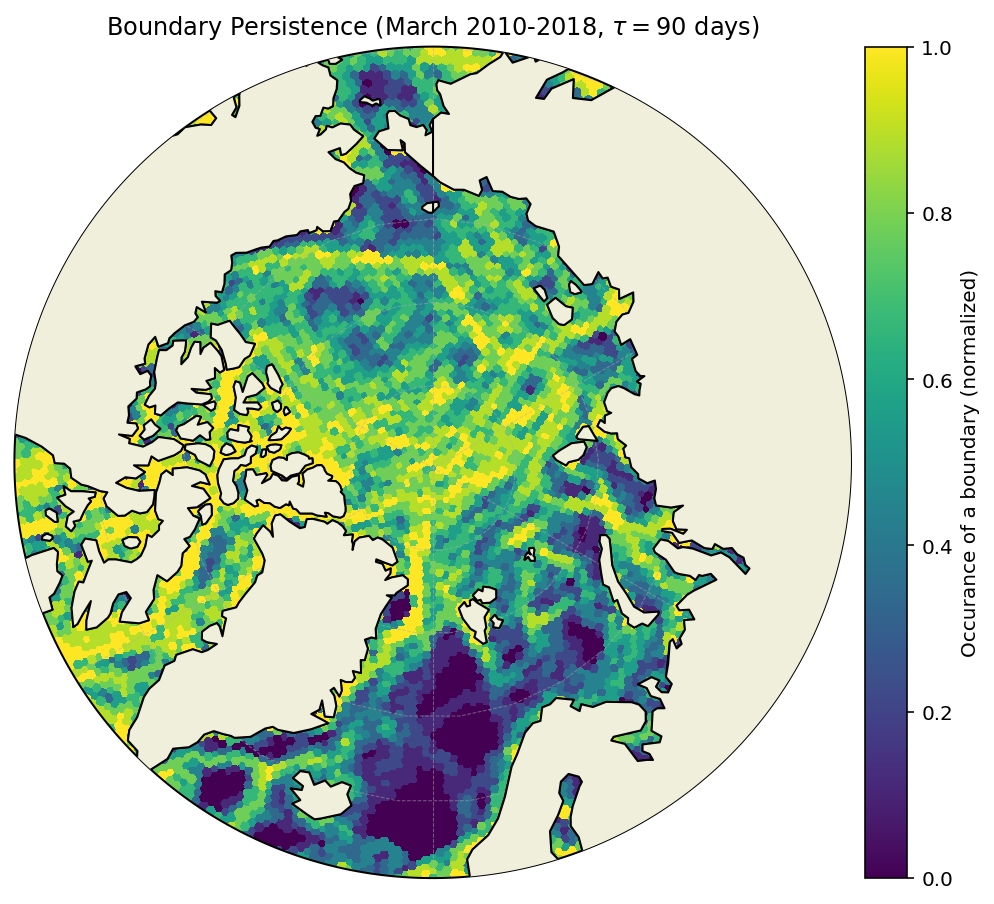

In [31]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_march_2010_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             export = f"persistence_Rcmems_Pico11_S20002018-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Boundary Persistence (March 2010-2018, $\tau=90$ days)",
                                             units = "Occurance of a boundary (normalized)"
                                            )

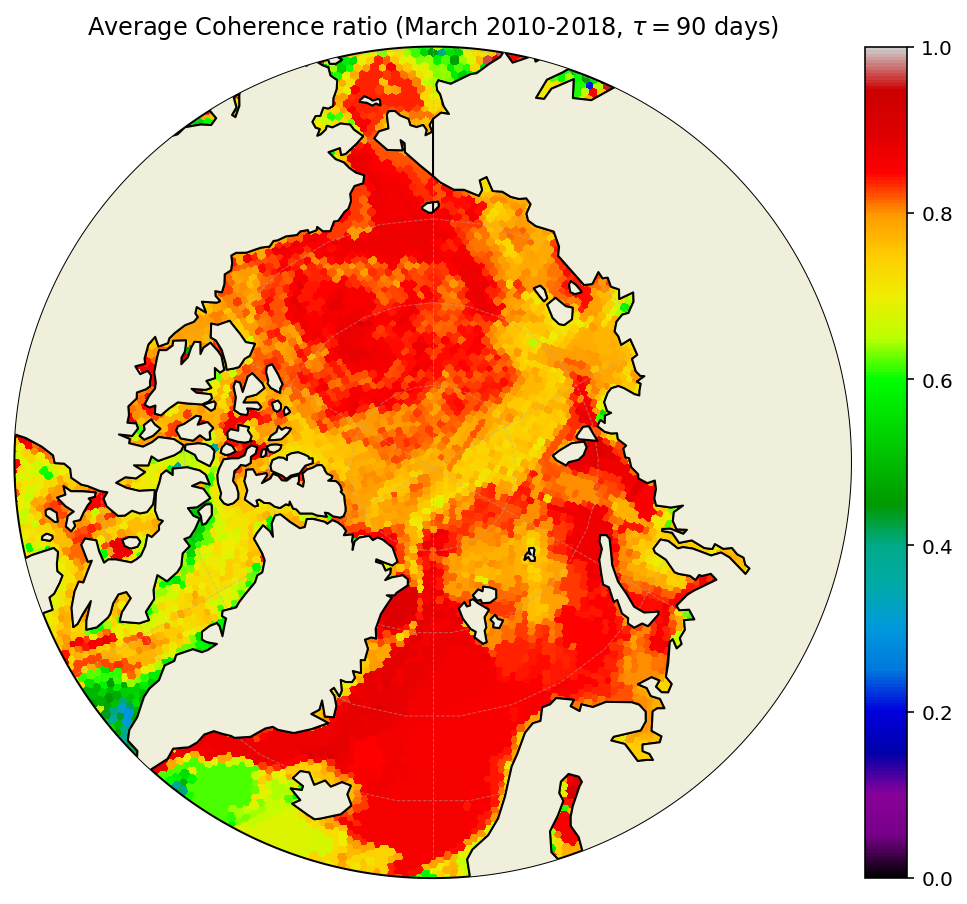

In [32]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_march_2010_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"coherence_Rcmems_Pico11_S20002018-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Coherence ratio (March 2010-2018, $\tau=90$ days)",
                                            )

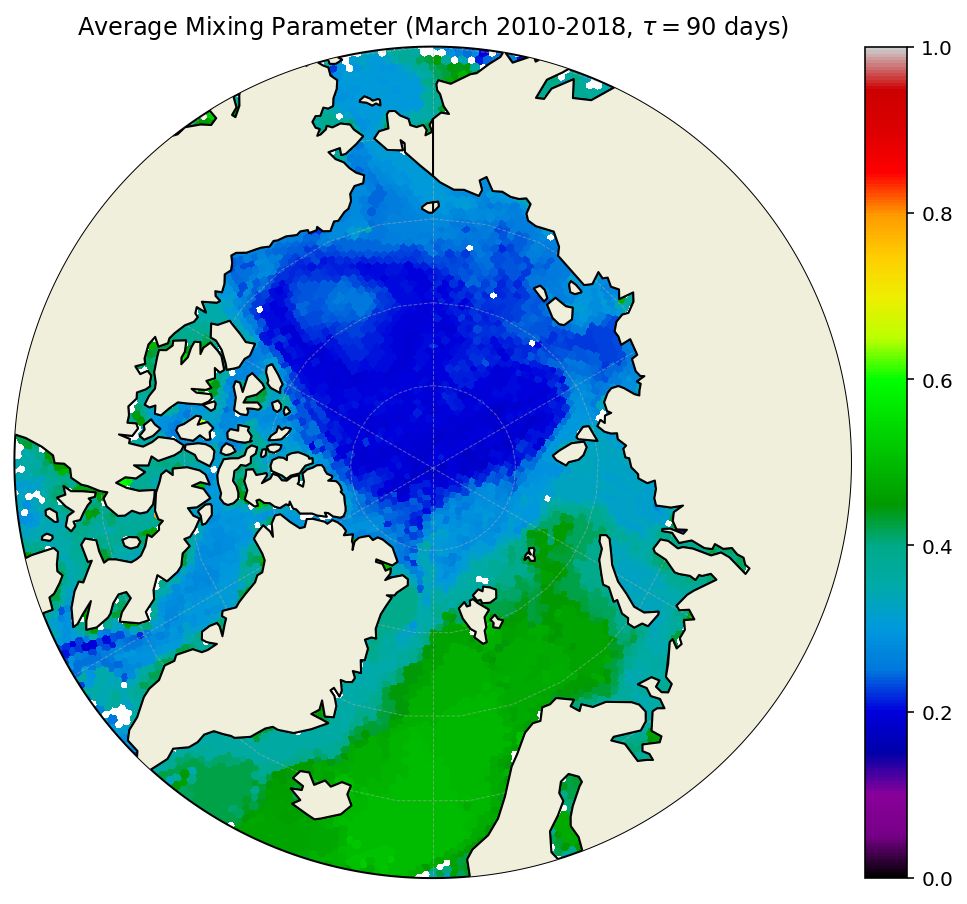

In [33]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_march_2010_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"mixing_Rcmems_Pico11_S20002018-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Mixing Parameter (March 2010-2018, $\tau=90$ days)",
                                            )

## September 2010-2018

In [8]:
avg_mixing_september_2010_2018 = np.zeros_like(myBins.bindex)
avg_coherence_september_2010_2018 = np.zeros_like(myBins.bindex)
avg_boundary_september_2010_2018 = np.zeros_like(myBins.bindex)
avg_global_mixing_september_2010_2018 = 0
avg_global_coherence_september_2010_2018 = 0

for year in range(2010, 2019):
    runName = f"Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24"
    comName = runName + "_Cico7_mt2"
    
    transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")
    
    myBins.load_communities(comdir + f"masked_network_{comName}.clu")
    myBins.find_adjacency();
    myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    
    avg_mixing_september_2010_2018 = avg_mixing_september_2010_2018 + myBins.mixing
    avg_coherence_september_2010_2018 = avg_coherence_september_2010_2018 + myBins.coherenceRatio
    avg_boundary_september_2010_2018 = avg_boundary_september_2010_2018 + myBins.onBoundary
    avg_global_coherence_september_2010_2018 += myBins.globalCoherenceRatio
    avg_global_mixing_september_2010_2018 += myBins.globalMixing
    
avg_mixing_september_2010_2018 = avg_mixing_september_2010_2018/9
avg_coherence_september_2010_2018 = avg_coherence_september_2010_2018/9
avg_boundary_september_2010_2018 = avg_boundary_september_2010_2018/9
avg_global_mixing_september_2010_2018 = avg_global_mixing_september_2010_2018/9
avg_global_coherence_september_2010_2018 = avg_global_coherence_september_2010_2018/9
print("Average Global Coherence Ratio", avg_global_coherence_september_2010_2018)
print("Average Global Mixing Parameter", avg_global_mixing_september_2010_2018)

Average Global Coherence Ratio 0.8074473046430302
Average Global Mixing Parameter 0.3396688601401939


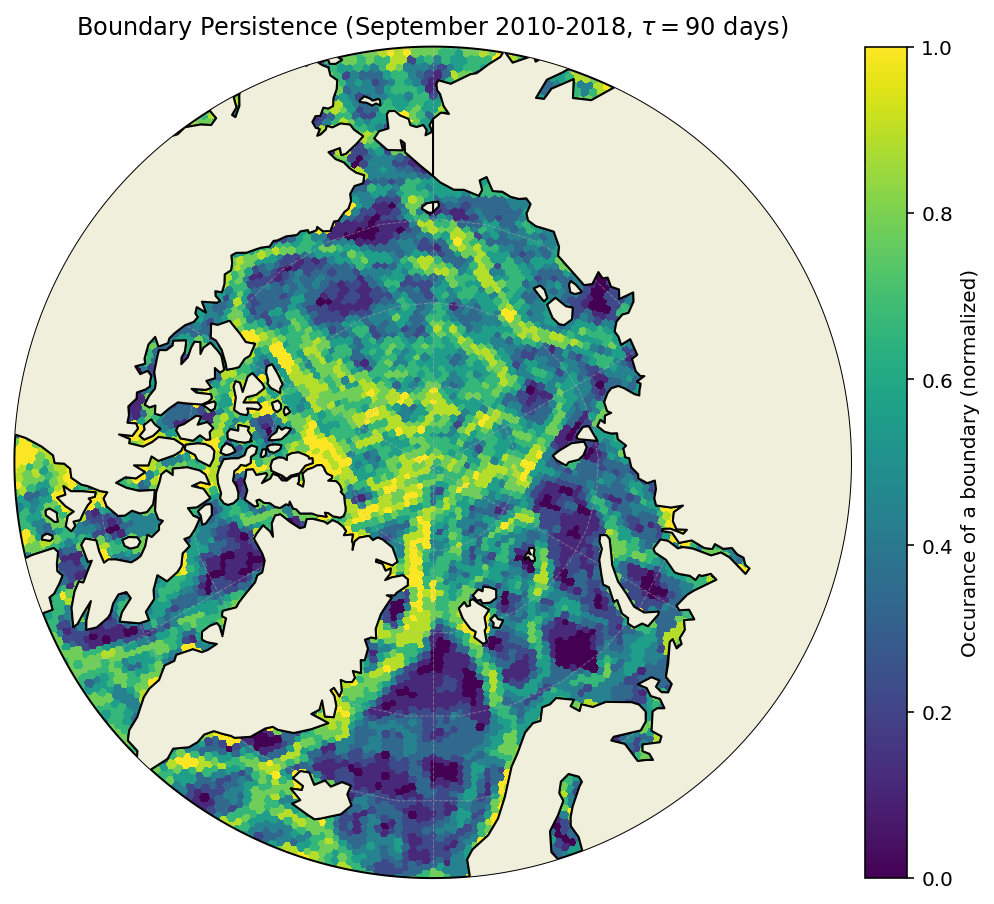

In [9]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_september_2010_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             export = f"persistence_Rcmems_Pico11_S20102018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Boundary Persistence (September 2010-2018, $\tau=90$ days)",
                                             units = "Occurance of a boundary (normalized)"
                                            )

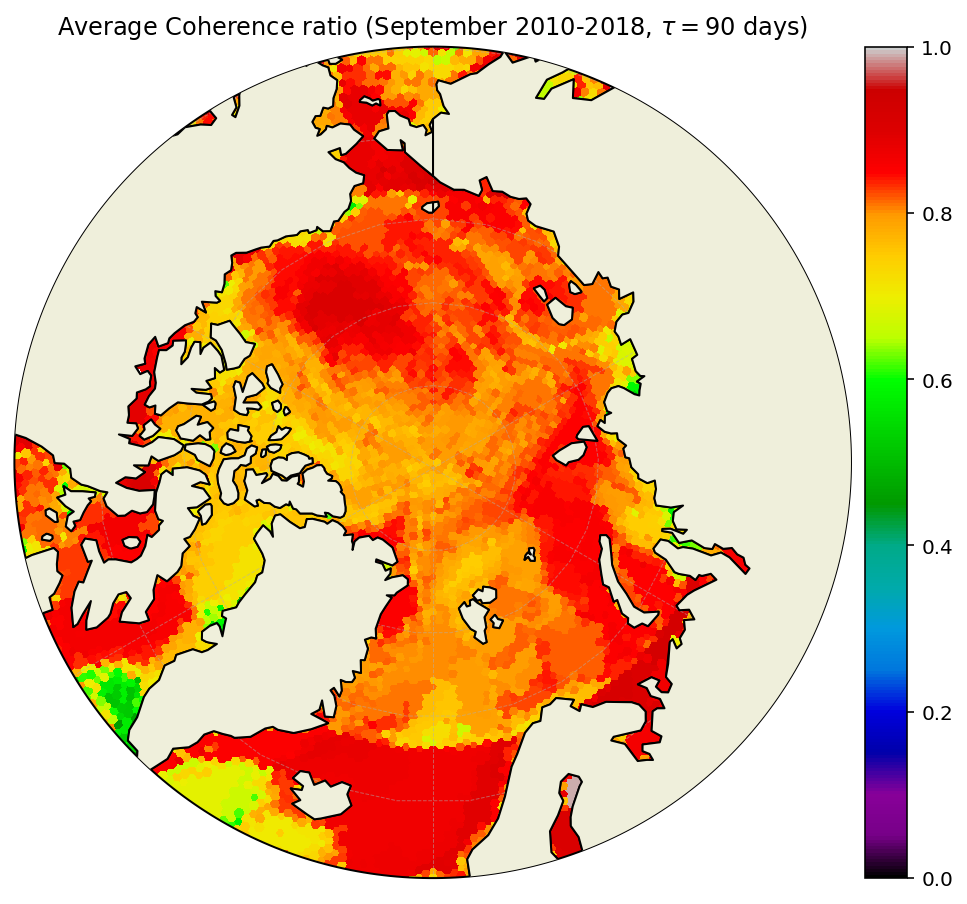

In [10]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_september_2010_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"coherence_Rcmems_Pico11_S20102018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Coherence ratio (September 2010-2018, $\tau=90$ days)",
                                            )

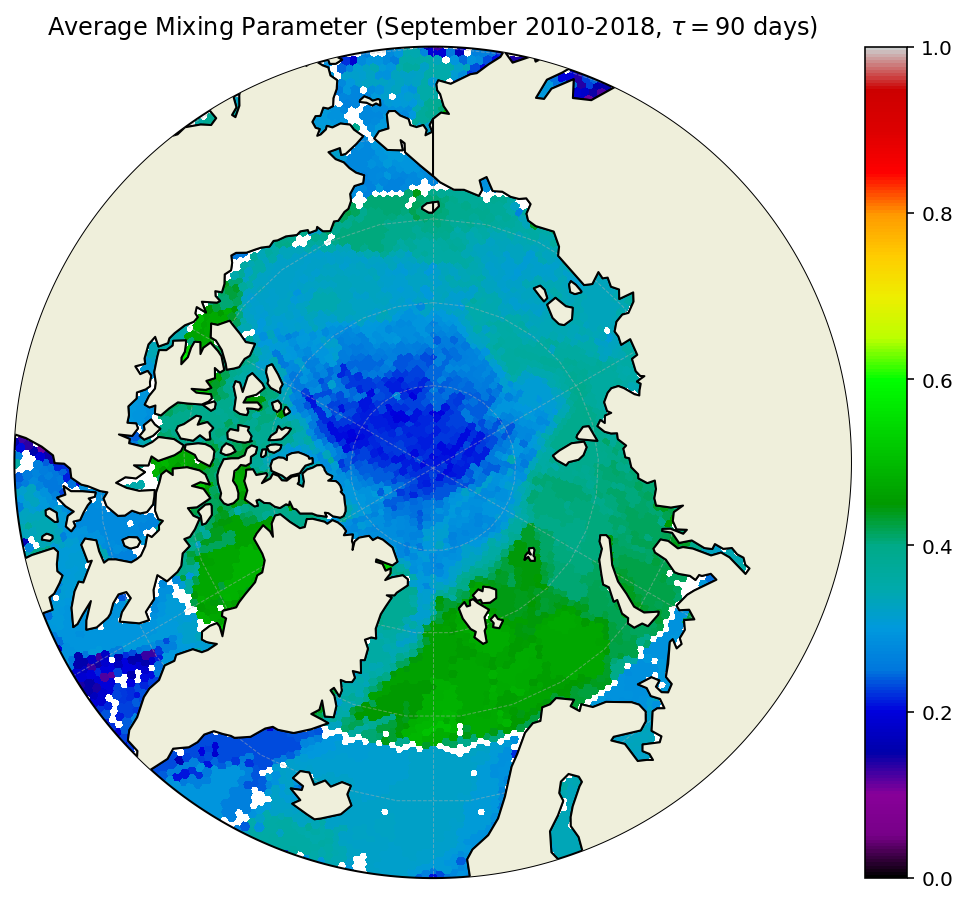

In [11]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_september_2010_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"mixing_Rcmems_Pico11_S20102018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Mixing Parameter (September 2010-2018, $\tau=90$ days)",
                                            )

### just September 2018

In [25]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"

In [27]:
transMat_20180901_90d = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")

In [28]:
runName = "Rcmems_Pico11_S2018-9-1_D90_DT20_ODT24"
comName = runName + "_Cico7_mt2"
myBins.load_communities(comdir + f"masked_network_{comName}.clu")
myBins.find_adjacency();
myBins.flag_on_boundary();
myBins.color_communities();
myBins.calculate_coherence_ratio(transMat_20180901_90d);
myBins.calculate_global_coherence()
myBins.calculate_mixing(transMat_20180901_90d);
myBins.calculate_global_mixing()
print("Global Coherence Ratio", myBins.globalCoherenceRatio)
print("Global Mixing Parameter", myBins.globalMixing)

Global Coherence Ratio 0.7865689860552483
Global Mixing Parameter 0.3774891922945967


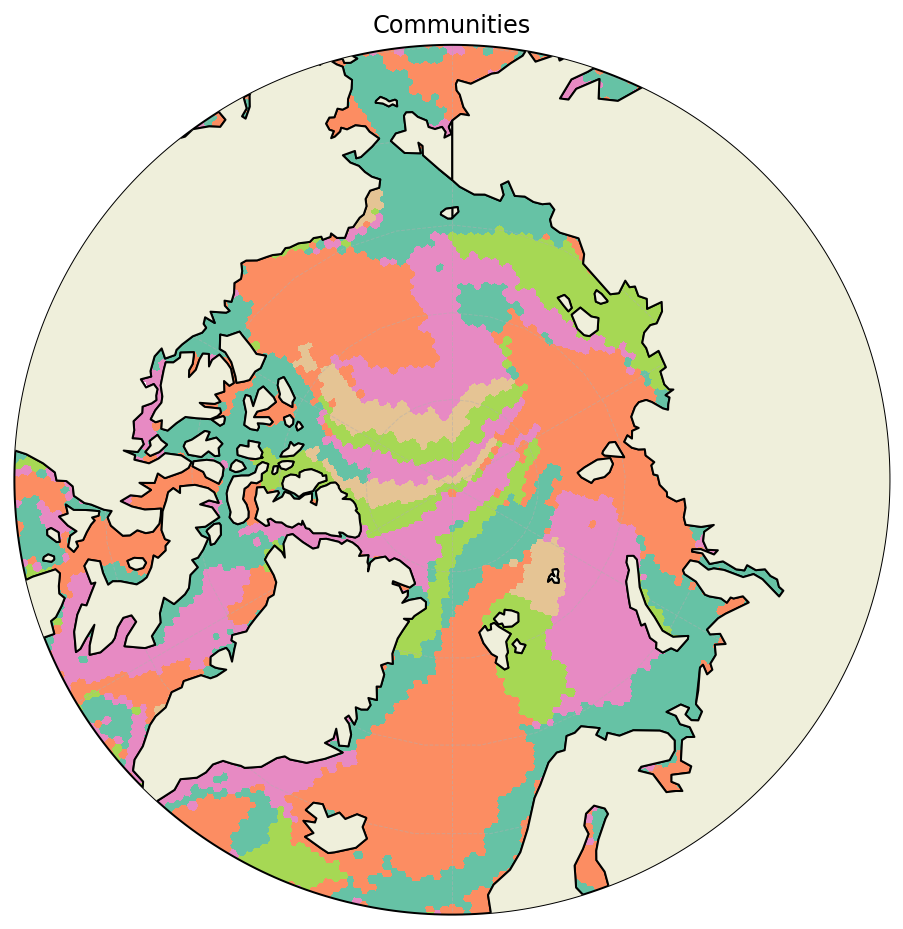

In [29]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.colorID[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "Set2",
                                             size = (8,8),
                                             export = f"{comName}.png",
                                             cbar=False,
                                             polar = True,
                                             title = "Communities"
                                            )